In [1]:
#Fill these file paths with the locations on your machine. 
PATH_TO_CODE = '/Users/kingrst15/Documents/ECE379K/TeamProjectCode/CV_Project_2024/pastis-benchmark/code' # path to the code folder of the repo
PATH_TO_PASTIS = '/Users/kingrst15/Documents/ECE379K/TeamProjectCode/PASTIS'


import sys
sys.path.append(PATH_TO_CODE)


import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib

cm = matplotlib.colormaps.get_cmap('tab20')
def_colors = cm.colors
cus_colors = ['k'] + [def_colors[i] for i in range(1,20)]+['w']
cmap = ListedColormap(colors = cus_colors, name='agri',N=21)

def get_rgb(x, batch_index=0, t_show=1):
    """Utility function to get a displayable rgb image 
    from a Sentinel-2 time series.
    """
    im = x['S2'][batch_index, t_show, [2,1,0]].cpu().numpy()
    mx = im.max(axis=(1,2))
    mi = im.min(axis=(1,2))   
    im = (im - mi[:,None,None])/(mx - mi)[:,None,None]
    im = im.swapaxes(0,2).swapaxes(0,1)
    im = np.clip(im, a_max=1, a_min=0)
    return im

def get_radar(x, batch_index=0, t_show=6, orbit='D'):
    """Utility function to get a displayable image 
    from a Sentinel-1 time series.
    """
    im = x['S1{}'.format(orbit)][batch_index, t_show].cpu().numpy()
    mx = im.max(axis=(1,2))
    mi = im.min(axis=(1,2))   
    im = (im - mi[:,None,None])/(mx - mi)[:,None,None]
    im = im.swapaxes(0,2).swapaxes(0,1)
    im = np.clip(im, a_max=1, a_min=0)
    return im

In [2]:
from dataloader import PASTIS_Dataset
from collate import pad_collate

dt = PASTIS_Dataset(PATH_TO_PASTIS, norm=True, target='semantic')
# If you only need to evaluate semantic segmentation use target='semantic'

dl = torch.utils.data.DataLoader(dt, batch_size=300, collate_fn=pad_collate, shuffle=True)

Reading patch metadata . . .
Done.
Dataset ready.


In [3]:
# Loading a batch from the dataloader
(x, dates), y = dl.__iter__().__next__()

# x is a dictionary thay contains the Sentinel-2 time series
# in the 'S2' key, shape: B x T x C x H x W
print(x.keys())
print(x['S2'].shape)
# dates contains the observation dates of each image, shape: B x T
print(dates['S2'].shape)
# y is the target label, shape: B x H x W
print(y.shape)

dict_keys(['S2'])
torch.Size([300, 61, 10, 128, 128])
torch.Size([300, 61])
torch.Size([300, 128, 128])


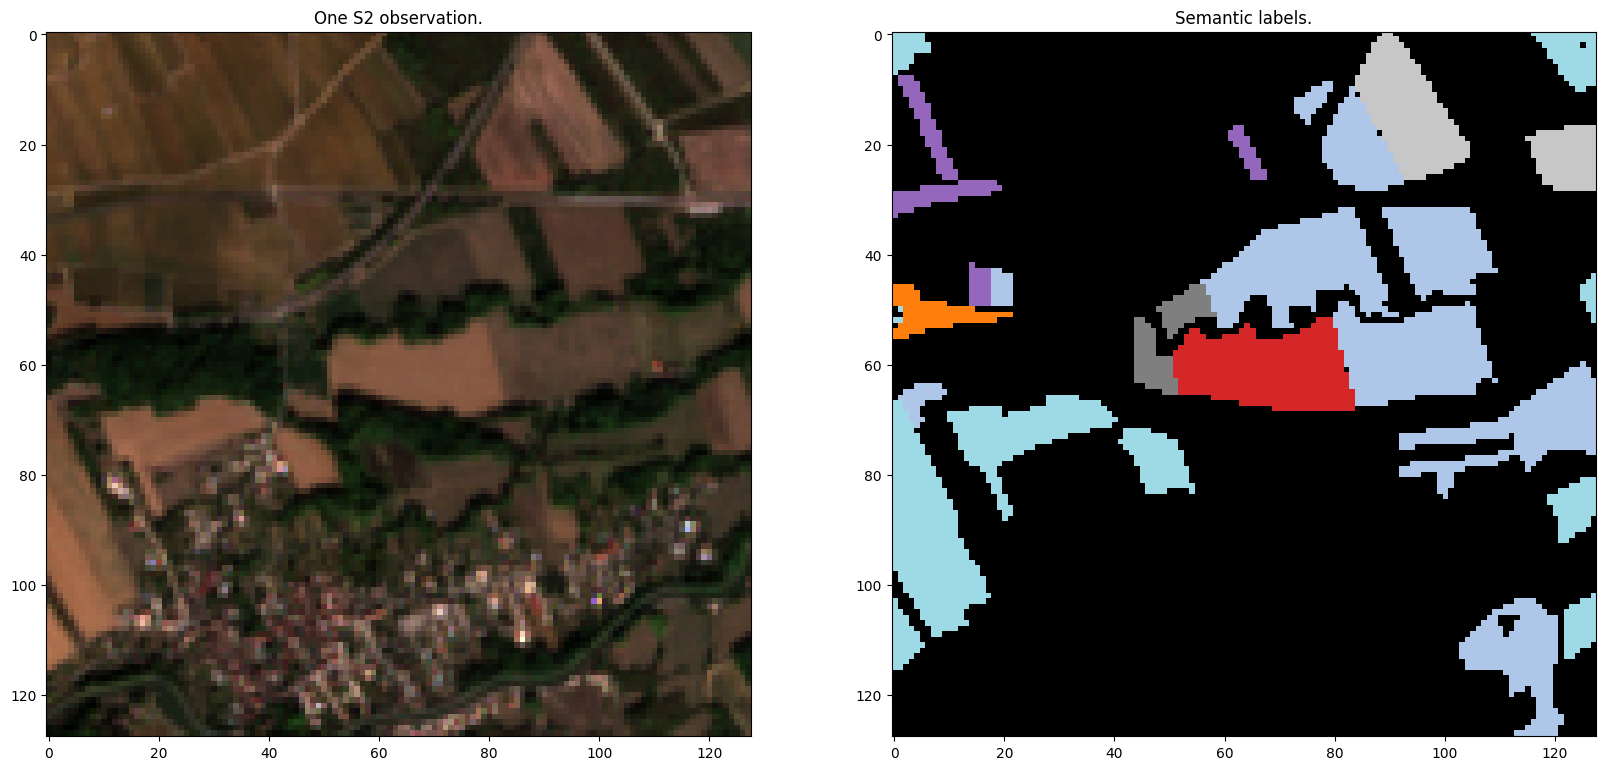

In [4]:
bid = 0 # Which element of the batch to plot

fix, axes = plt.subplots(1,2, figsize=(20,20))

axes[0].imshow(get_rgb(x, batch_index=bid))
axes[1].imshow(y[bid].squeeze(), cmap=cmap, vmin=0, vmax=20)

axes[0].set_title('One S2 observation.')
axes[1].set_title('Semantic labels.')

plt.show()

In [5]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, jaccard_score

In [6]:
x_flat = x['S2'].numpy()
x_flat = x_flat[:, 0, :, :, :]
x_flat = x_flat.reshape([x_flat.shape[0], -1])
x_flat.shape

(300, 163840)

In [7]:
# Flatten the labels
y_flat = y.view(y.shape[0], -1).numpy()
y_flat.shape

(300, 16384)

In [8]:
x_train, x_test, y_train, y_test = train_test_split(x_flat, y_flat, test_size=0.33, random_state=42)

In [9]:
knn = KNeighborsClassifier(n_neighbors=4, algorithm='kd_tree', leaf_size=10)
x_train = x_train.reshape(x_train.shape[0], -1)
print(x_train.shape)
print(y_train.shape)
knn.fit(x_train, y_train)

(201, 163840)
(201, 16384)


KNeighborsClassifier(algorithm='kd_tree', leaf_size=10, n_neighbors=4)

In [10]:
y_test.shape

(99, 16384)

In [16]:
# Predict
x_test = x_test.reshape(x_test.shape[0], -1)
y_pred = knn.predict(x_test)

# Evaluate
y_test = y_test.flatten()
y_pred = y_pred.flatten()

print(y_test.shape)
print(y_pred.shape)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
iou = jaccard_score(y_test, y_pred, average='weighted')

print('Accuracy: ', accuracy)
print('F1: ', f1)
print('Recall: ', recall)
print('Precision: ', precision)
print('IoU (Jaccard Score): ', iou)


(1622016,)
(1622016,)
Accuracy:  0.33147761797664144
F1:  0.2772431125681197
Recall:  0.33147761797664144
Precision:  0.28443541583433635
IoU (Jaccard Score):  0.17664276111983468


In [12]:
dl_ex = torch.utils.data.DataLoader(dt, batch_size=100, collate_fn=pad_collate, shuffle=True)
(x_ex, dates), y_ex = dl_ex.__iter__().__next__()
# Flatten the time series
x_ex_flat = x_ex['S2'].numpy()
x_ex_flat = x_ex_flat[:, 0, :, :, :]
x_ex_flat = x_ex_flat.reshape([x_ex_flat.shape[0], -1])

# Flatten the labels
y_ex_flat = y_ex.view(y_ex.shape[0], -1)

Text(0.5, 1.0, 'Semantic labels.')

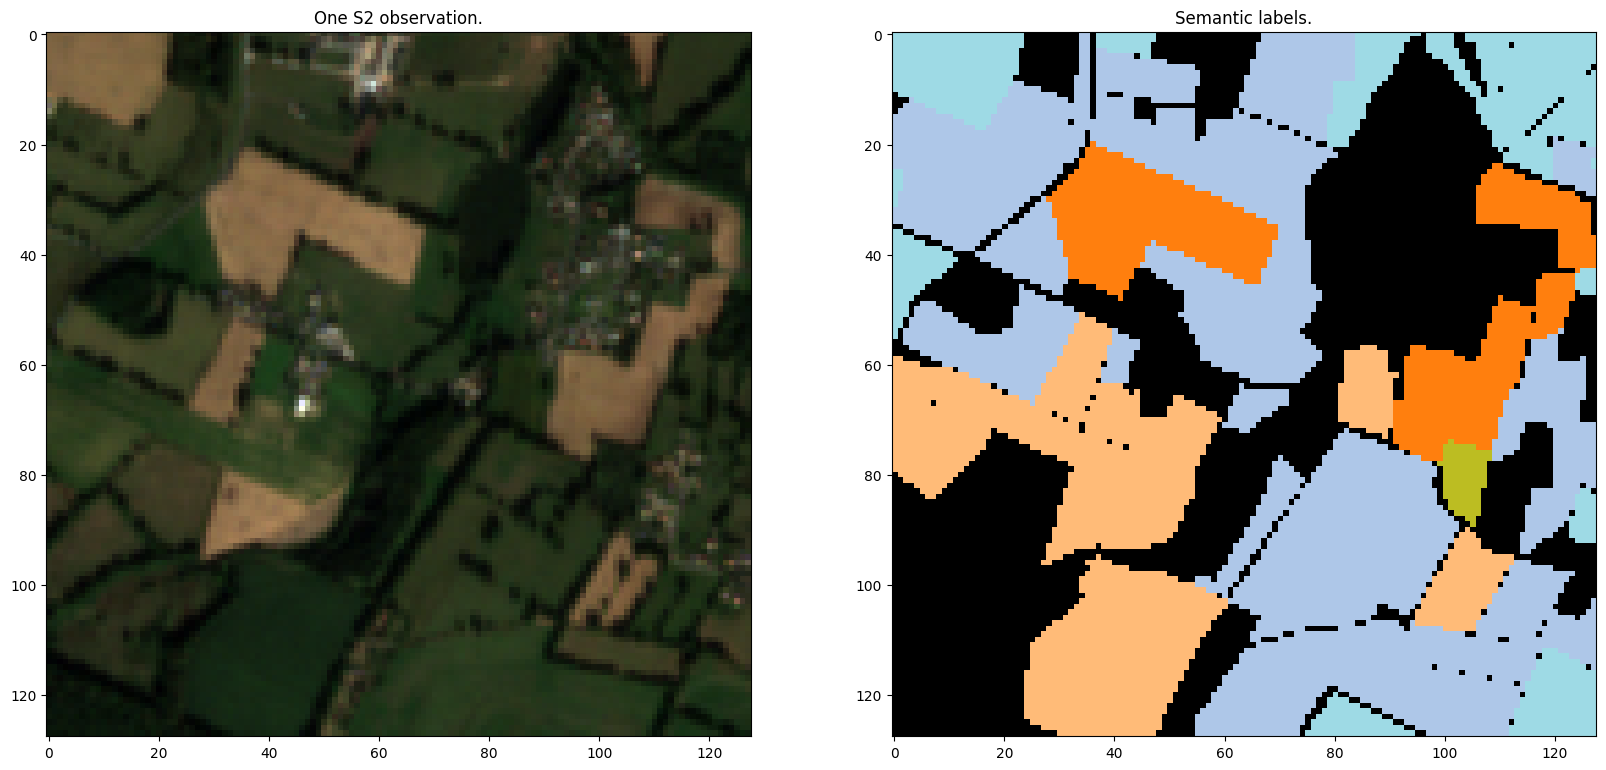

In [13]:
bid = 0 # Which element of the batch to plot

fix, axes = plt.subplots(1,2, figsize=(20,20))

axes[0].imshow(get_rgb(x_ex, batch_index=bid))
axes[1].imshow(y_ex[bid].squeeze(), cmap=cmap, vmin=0, vmax=20)

axes[0].set_title('One S2 observation.')
axes[1].set_title('Semantic labels.')


In [14]:
y_ex_pred = knn.predict(x_ex_flat[0, :].reshape([1, -1]))
y_ex_pred = y_ex_pred.reshape([128, 128])

Text(0.5, 1.0, 'Ground Truth')

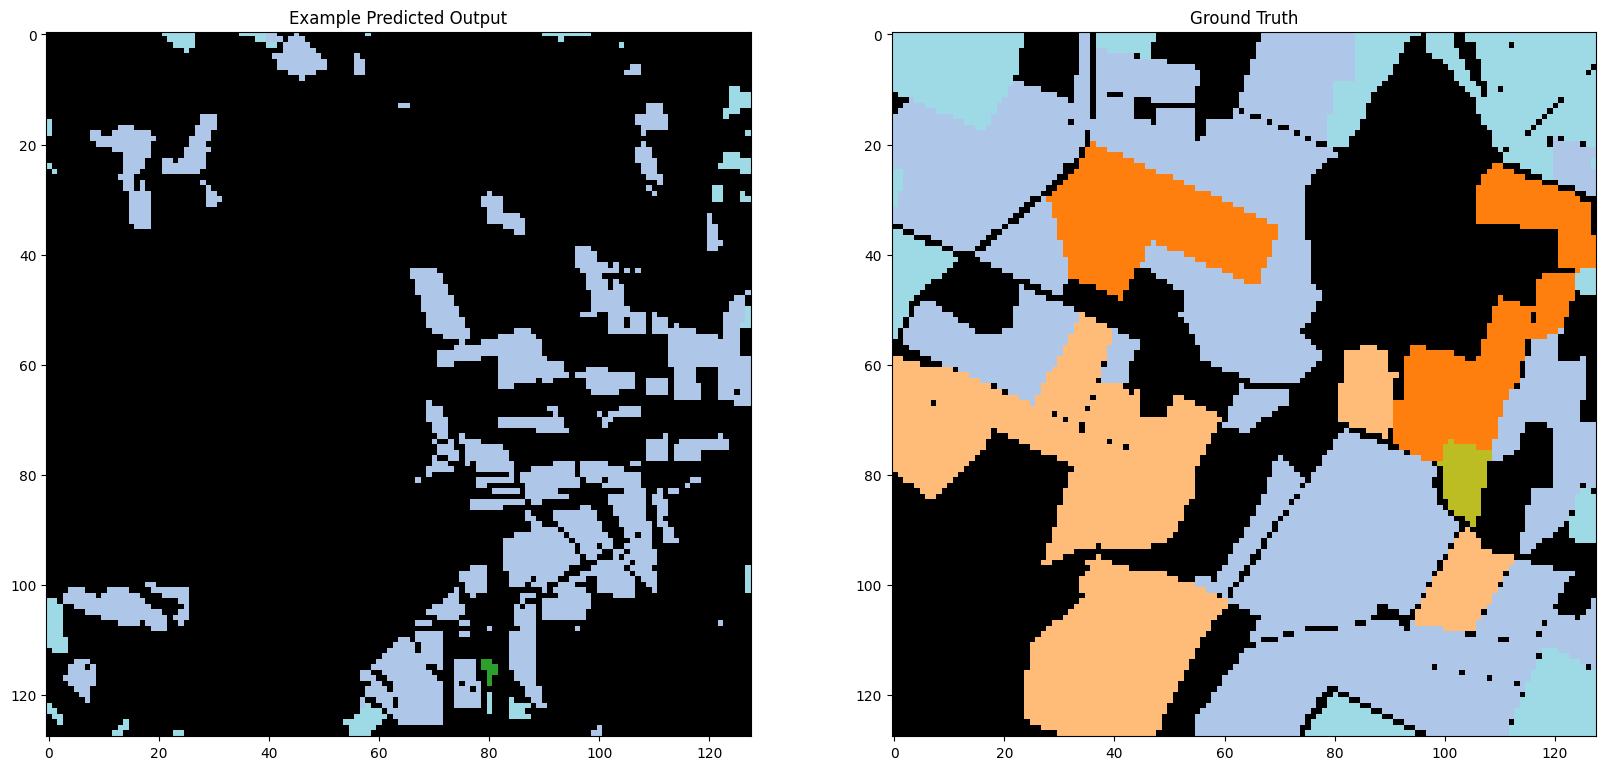

In [15]:
fix, axes = plt.subplots(1,2, figsize=(20,20))

axes[0].imshow(y_ex_pred, cmap=cmap, vmin=0, vmax=20)
axes[1].imshow(y_ex[0].squeeze(), cmap=cmap, vmin=0, vmax=20)

axes[0].set_title('Example Predicted Output')
axes[1].set_title('Ground Truth')